### Example 1
# Calculate Labusch parameters
**Author**: Gerard Paul Marcelo Leyson

**Date**: 2016-11-03

### Summary:
This notebook shows how the labusch module can be used to calculate normalized parameters using the modified Labusch model. 

#### Output:
Specifically, we want to calculate the following parameters:
- $\tau_{y0} / c^{2/3}$ - the normalized zero-temperature yield stess
- $\Delta E_b/ c^{1/3}$ - the normalized characteristic energy barrier
- $\zeta_c \cdot c^{1/3}$ - the normalized characteristic length scale
- $w_c$ - the characteristic roughening amplitude

#### Input:
To calculate these parameters, we need:
- $U_{int}(x, y)$ - the solute-dislocation interaction energy in (eV)
- $w_{step}$ - the increment along the dislocation glide direction in (A)
- $\Gamma$ - dislocaiton line tension in (eV/A)

To compute the solute-dislocation interaction energy, we are going to use the `SpreadCoreDislocation` class, which is a daughter of the `DislocationArray` class.  For that, we need the following parameters:
- $\mu, \nu$ - the shear modulus in (GPa) and Poisson's ratio
- $\Delta v_m$ - misfit volume of the solute
- $b$ - the Burgers vector

## Load modules

In [1]:
%matplotlib inline

from __future__ import print_function

import labusch as lb
import numpy as np
import matplotlib.pyplot as plt

## Define parameters for the Al-X system

#### Dislocation line tension

In [2]:
Gamma = 0.47          # eV/A

#### Parameters related to the matrix

In [3]:
host = 'Al'

# define elastic parameters
c11 = 108.5           # GPa
c12 =  56.8           # GPa
c44 =  30.5           # GPa

mu = (c11+c44-c12)/3. # GPa
nu = 0.33             # unitless
elconst = lb.ElasticConstants(mu=mu, nu=nu)

# define 
a0 = 4.0413           # A
bvec = a0/np.sqrt(2.) # A

#### Parameters related to the solutes

In [4]:
# define misfit volumes
dv_mg = 5.71          # A^3
dv_mn = -13.32        # A^3

## Define auxilliary functions

In [5]:
def generate_atom_positions(xstep, ystep, iwidth_x=250, iwidth_y=250):
    """
    Generate atomic positions.
    
    :params:
        xstep(float): spacing in the x-direction in (A)
        ystep(float): spacing in the y-direction in (A)
        iwidth_x(int): width in the x-direction
        iwidth_y(int): width in the y-direction
        
    :returns:
        (Coordinates_2d): x- and y- coordinates of atoms
    """
    xvar = (np.arange(-iwidth_x, iwidth_x)) * xstep
    yvar = (np.arange(-iwidth_y, iwidth_y) + 0.5) * ystep
    xx, yy = np.meshgrid(xvar, yvar)
    return lb.Coordinates_2d(x=xx, y=yy)

In [76]:
def visualize_dislocation(disl, field, figsize=(10, 7), xlim=[-20, 20], ylim=[-20, 20],
                          msize = 20, cmap='coolwarm'):
    """Scatter plot of dislocation with atoms colored according field"""
    x = disl.rdef.x.flatten()
    y = disl.rdef.y.flatten()

    plt.figure(figsize=figsize)
    plt.scatter(x, y, c=field, s=msize, cmap=cmap)
    plt.plot(disl.xdisl_array, disl.ydisl_array, 'kx')
    plt.axis('equal')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.colorbar()
    
    plt.xlabel('x (A)')
    plt.ylabel('y (A)')

In [77]:
def plot_DEtotpL_vs_w(model, figsize=(6, 4), xlim=None, ylim=None):
    """Plots the normalized total energy per unit length versus w"""
    mask = model._DEtotpL == model._DEtotpL.min()

    plt.figure(figsize=figsize)
    plt.plot(model._warray, model._DEtotpL, '-k', lw=2)
    plt.plot(model._warray[mask], model._DEtotpL[mask], 'ko', ms=8)
    
    plt.xlabel('w (A)')
    plt.ylabel('norm. E per L (eV/A)')
    
    if xlim:
        plt.xlim(xlim)
    else:
        plt.xlim([0, model._warray.max()])
    if ylim:
        plt.ylim(ylim)

## Calculate solute-dislocation interaction energy using the spread core model

In [78]:
# generate atomic positions
xstep = a0*np.sqrt(2.)/4.
ystep = a0*np.sqrt(3.)/3.
iwidth_x = 250
iwidth_y = 250
ratoms = generate_atom_positions(xstep, ystep, iwidth_x=iwidth_x, 
                                 iwidth_y=iwidth_y)

In [79]:
# define spread-core model
ndisl = 11
disl_spacing = xstep

bedge = bvec
bscrew = 0.
rdisl_center = lb.Coordinates_2d(x=0., y=0.)

disl = lb.SpreadCoreDislocation(elconst, ratoms, bedge, bscrew, disl_spacing,
                                ndisl=ndisl, rdisl_center=rdisl_center)

In [80]:
# calculate interaction energy
Uint_mg = disl.calc_interaction_energy(dv=dv_mg)
Uint_mn = disl.calc_interaction_energy(dv=dv_mn)

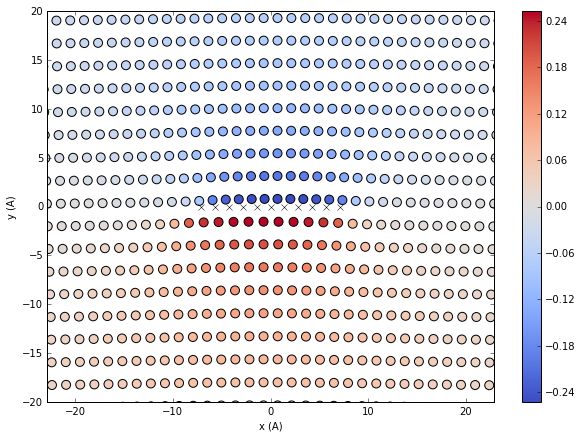

In [81]:
# visualize dislocation
visualize_dislocation(disl, Uint_mn, msize=80)

## Calculate Labsuch parameters

In [82]:
# define model
name = 'Al-Mg, no dft'
model_mg = lb.SoluteStrengtheningMinization(Uint=Uint_mg, wstep=xstep, bvec=bvec, 
                                            Gamma=Gamma, ishift_max=100, 
                                            name=name, host=host, solute='Mg')
lp_almg = model_mg.get_Labusch_params()
lp_almg.print_parameters()

name  : Al-Mg, no dft
host  : Al
solute: Mg
nty0  : 339.5049 MPa
nDEb  : 4.0499 eV
nzeta : 66.7511 A
wc    : 15.7170 A
Gamma : 0.4700 eV/A


In [83]:
# define model
name = 'Al-Mn, no dft'
model_mn = lb.SoluteStrengtheningMinization(Uint=Uint_mn, wstep=xstep, bvec=bvec, 
                                            Gamma=Gamma, ishift_max=100, 
                                            name=name, host=host, solute='Mg')
lp_almn = model_mn.get_Labusch_params()
lp_almn.print_parameters()

name  : Al-Mn, no dft
host  : Al
solute: Mg
nty0  : 1050.3569 MPa
nDEb  : 7.1234 eV
nzeta : 37.9501 A
wc    : 15.7170 A
Gamma : 0.4700 eV/A


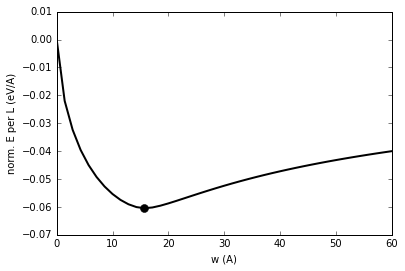

In [84]:
# visualize normalized total energy per unit length vs. w
plot_DEtotpL_vs_w(model_mn, xlim=[0, 60])

In [85]:
lp_almg.save(filename='labusch_params_Al-Mg_elastic', directory='data')
lp_almn.save(filename='labusch_params_Al-Mn_elastic', directory='data')

In [86]:
lp_almg.print_parameters()
print()
lp_almg.Gamma = 0.25
lp_almg.print_parameters()

name  : Al-Mg, no dft
host  : Al
solute: Mg
nty0  : 339.5049 MPa
nDEb  : 4.0499 eV
nzeta : 66.7511 A
wc    : 15.7170 A
Gamma : 0.4700 eV/A

name  : Al-Mg, no dft
host  : Al
solute: Mg
nty0  : 419.0174 MPa
nDEb  : 3.2814 eV
nzeta : 66.7511 A
wc    : 15.7170 A
Gamma : 0.2500 eV/A


In [87]:
Uint_mg.shape

(500, 500)

In [88]:
help(lb.SoluteStrengtheningMinization)

Help on class SoluteStrengtheningMinization in module labusch.solute_strengthening:

class SoluteStrengtheningMinization(__builtin__.object)
 |  Class to calculate normalized parameters from solute-dislocation
 |  interaction energies using the modified Labsuch model.
 |  
 |  :params:
 |      Uint(numpy ndarray): solute-dislocaiton interaction energy
 |      wstep(float): the incremental distance traveled by the
 |                    dislocation in (A)
 |      bvec(float) : the Burgers vector in (A)
 |      Gamma(float): the dislocation line tension in (eV/A)
 |      ishift_max(int): max increments used in the minimization
 |      name(string): name of the system
 |      host(string): name of host matrix
 |      solute(string): name of solute
 |  
 |  Methods defined here:
 |  
 |  __init__(self, Uint=nan, wstep=nan, bvec=nan, Gamma=nan, ishift_max=100, name='Unnamed', host='unkown', solute='unkown')
 |  
 |  get_Labusch_params(self)
 |      Returns the Labusch paramters
 |  
 |  prin